## 1. Importing data, merging

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# df is the merged dataset (train + test)
df = pd.concat((train, test)).reset_index(drop=True)

/Users/chloeymoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



/Users/chloeymoon/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chloeymoon/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

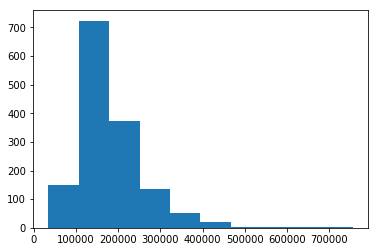

In [3]:
# ** skewed so we need to log transform **
plt.hist(df.SalePrice)

## 2. Overall EDA (Distribution by variable)

In [4]:
#allvars = list(df.columns)

In [5]:
# helper function to visualize distribution
def visdist(df,col):
    plt.subplot(1, 2, 1)
    plt.hist(df[col])
    plt.subplot(1, 2, 2)
    plt.scatter(df[col],df['SalePrice'])
    plt.tight_layout()
    plt.show()

In [6]:
cat_colnames = df.select_dtypes(include=['object']).columns
#print(cat_colnames, len(cat_colnames))
num_colnames = df.select_dtypes(exclude = ["object"]).columns
#print(num_colnames,len(num_colnames))

## 3. Data Cleaning: Missing Value Imputation

In [7]:
def clean(df):
    # **** what to do with Year and Month?
    for var in ['MSSubClass']:
        # later on, change to the actual string values
        df[var] = df[var].apply(str)
        
    # no garage, no bathrooms, etc., based on data description?  
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
        df[col] = df[col].fillna(0).astype(int)
        
    # Replacing missing data with None, based on data description
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
        df[col] = df[col].fillna('None')
            
    # Home functionality (Assume typical unless deductions are warranted): 
    # data description says NA means typical
    df['Functional'] = df['Functional'].fillna('Typ')
    
    # lot frontage: correlated with lot area (0.48) and neighborhoods (domain expertise)
    df = cleanLotFrontage(df)

    # ****** MSZoning, grouped by MSSubClass but I'm not exactly sure this is valid
    # did chi square test, wasn't too helpful, so many other categorical variables associated as much
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    common_vars = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
    for var in common_vars:
        df[var] = df[var].fillna(df[var].mode()[0])
    
    return df

def cleanLotFrontage(df):
    df['LotArea_bin'] = pd.cut(df['LotArea'],50).apply(lambda x: x.mid)
    df['Lotfrontage_grouped'] = df.groupby(['Neighborhood','LotArea_bin'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    df['Lotfrontage_grouped'] = df.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    #df['LotFrontage_neigh'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    #df['LotFrontage_lotarea'] = df.groupby('LotArea')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    df['LotFrontage'] = df['Lotfrontage_grouped']
    df = df.drop(columns=['LotArea_bin','Lotfrontage_grouped']) 
    return df

In [8]:
# garage
#df[['GarageType','GarageFinish','GarageQual','GarageCond']]

# basement
#df[['BsmtQual',"BsmtCond","BsmtExposure","BsmtFinSF1","BsmtFinSF2","BsmtFinType1","BsmtFinType2"]]

In [9]:
def computeMissingness(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    # df.boxplot(column='LotFrontage',by='Neighborhood')
    # plt.scatter(x=df.LotArea,y=df.LotFrontage)
    return missing_data

In [14]:
df[['SalePrice','FireplaceQu']]

,SalePrice,FireplaceQu
0,208500.0,NaN
1,181500.0,TA
2,223500.0,TA
3,140000.0,Gd
4,250000.0,TA
5,143000.0,NaN
6,307000.0,Gd
7,200000.0,TA
8,129900.0,TA
9,118000.0,TA


In [11]:
computeMissingness(df)
#computeMissingness(train).head()
#computeMissingness(df).head()

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [22]:
# clean the data and compute the % of missingness to confirm
cleaned = clean(test)
computeMissingness(cleaned).head(10)

,Total,Percent
SaleType,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685
KitchenQual,1,0.000685
TotalBsmtSF,0,0.000000
RoofMatl,0,0.000000
MasVnrType,0,0.000000
MasVnrArea,0,0.000000
ExterQual,0,0.000000
ExterCond,0,0.000000


### *~ Attempts to do the cleaning better; ignore for now ~*

In [31]:
# Chi square test: if two categorical variables are independent
# null: no association
# detects a significant relationship between the variables

import scipy.stats as stats

def chi_sq(df,a,b):
    tab = pd.crosstab(df[a],df[b],margins=True)
    tab.columns = list(tab.columns[:-1])+["row_totals"]
    tab.index = list(tab.index[:-1])+["col_totals"]
    #tab
    num_col = len(tab.columns)-1
    num_ind = len(tab.index)-1
    num_obs = len(df)
    deg_f = (num_col-1) * (num_ind-1)
    # observed and expected
    observed = tab.iloc[:num_ind,:num_col]
    expected = np.outer(tab["row_totals"][:num_ind],tab.loc["col_totals"][:num_col])/num_obs
    expected = pd.DataFrame(expected)
    expected.columns = list(tab.columns[:-1])
    expected.index = list(tab.index[:-1])
    # statistics
    chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
    print('chi squared stat: ',chi_squared_stat)
    crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                          df = deg_f)   # *
    print("Critical value: ",crit)
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                                 df=deg_f)
    print("P value: ",p_value)
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(observed= observed)
    print("P-val from the package",p_val)

In [32]:
def append_noBsmt(df):
    temp = df[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1',
                    'BsmtFinType2', 'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]
    temp["missingRows"] = temp.isnull().sum(axis=1) > 0
    bsmt_cat = temp.select_dtypes(include=['object'])
    bsmt_num = temp.select_dtypes(exclude=['object']).drop('missingRows',axis=1)
    bsmt_cat['cat_allnull'] = bsmt_cat.isnull().all(axis=1)
    bsmt_num['num_all0'] = bsmt_num.isin([0]).all(axis=1)
    bsmt = pd.concat((bsmt_cat, bsmt_num),axis=1).reset_index(drop=True)
    df["noBsmt"] = (bsmt["cat_allnull"]==True) & (bsmt["num_all0"]==True)
    return df

In [33]:
def append_noBsmt(df):
    temp = df[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1',
                    'BsmtFinType2', 'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]
    temp["missingRows"] = temp.isnull().sum(axis=1) > 0
    bsmt_cat = temp.select_dtypes(include=['object'])
    bsmt_num = temp.select_dtypes(exclude=['object']).drop('missingRows',axis=1)
    bsmt_cat['cat_allnull'] = bsmt_cat.isnull().all(axis=1)
    bsmt_num['num_all0'] = bsmt_num.isin([0]).all(axis=1)
    bsmt = pd.concat((bsmt_cat, bsmt_num),axis=1).reset_index(drop=True)
    df["noBsmt"] = (bsmt["cat_allnull"]==True) & (bsmt["num_all0"]==True)
    return df

In [ ]:
####### tree imputation ###### 

In [ ]:
#### random forest imputation works for numerical 
from missingpy import MissForest

#cat = df.select_dtypes(include=['object'])
num = df.select_dtypes(exclude = ["object"]).drop('SalePrice', axis=1)
num.isnull().fillna(float("NaN"))
imputer = MissForest(copy=True)
num_imputed = imputer.fit_transform(num)
num_imputed = pd.DataFrame(data=num_imputed, columns=num.columns)

In [ ]:
# med= df.groupby(['LotArea_bin_mid'])['LotFrontage'].transform('median')
# med
df['LotFrontage_groupNeigh'] = df.groupby(['Neighborhood']).transform(lambda x: x.fillna(x.median()))

In [ ]:
df['LotArea_bin_mid'] 

In [ ]:
df_num_imputed = df
for col in num_imputed.columns:
    df_num_imputed[col] = num_imputed[col]

In [ ]:
total = df_num_imputed.isnull().sum().sort_values(ascending=False)
percent = (df_num_imputed.isnull().sum()/df_num_imputed.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

In [ ]:
# dummifying everything for the random forest imputation purposes

cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df = df.append(pd.get_dummies(df[col],prefix=col))
    df = df.drop([col],axis=1)

In [ ]:
# trying for all dataframe
cat = df.select_dtypes(include=['object'])

df = df[["SaleType","SalePrice"]]#df.drop('SalePrice', axis=1)
df.isnull().fillna(float("NaN"))
imputer = MissForest(copy=True) 
df_imputed = imputer.fit(df,cat_vars=0) #[df.columns.get_loc(x) for x in cat]
df_imputed = imputer.transform()
df_imputed = pd.DataFrame(data=df_imputed, columns=df.columns)

### Re-run missing data to see if there is any missing data 

In [ ]:
computemissingdata(df)
# so we're all set!

### Split data into categorical vs. numerical for easier analysis

In [ ]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)
numerical_features = df.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
feat_num = df[numerical_features]
feat_cat = df[categorical_features]

## 4. Featuring engineering 

In [ ]:
#  Adding total sqfootage feature 
df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

#  Adding total bathrooms feature
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

#  Adding total porch sqfootage feature
df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

In [ ]:
# Make new indicator variable (present =1, not present = 0)
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
### Heatmap of sales price vs. 15 variables with top correlation 
# saleprice correlation matrix

corr_num = 15 #number of variables for heatmap
cols_corr = corrmat.nlargest(corr_num, 'SalePrice')['SalePrice'].index
corr_mat_sales = np.corrcoef(train[cols_corr].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(corr_mat_sales, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols_corr.values, xticklabels=cols_corr.values)
plt.show()